1/1 [==============================] - 0s 259ms/step


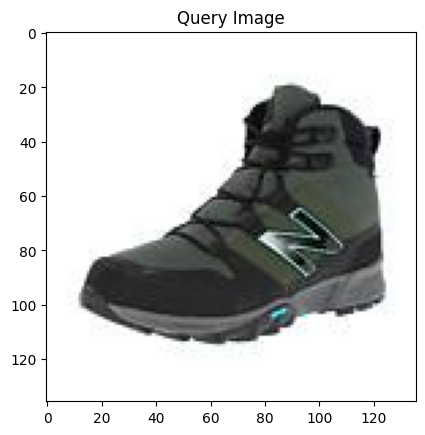

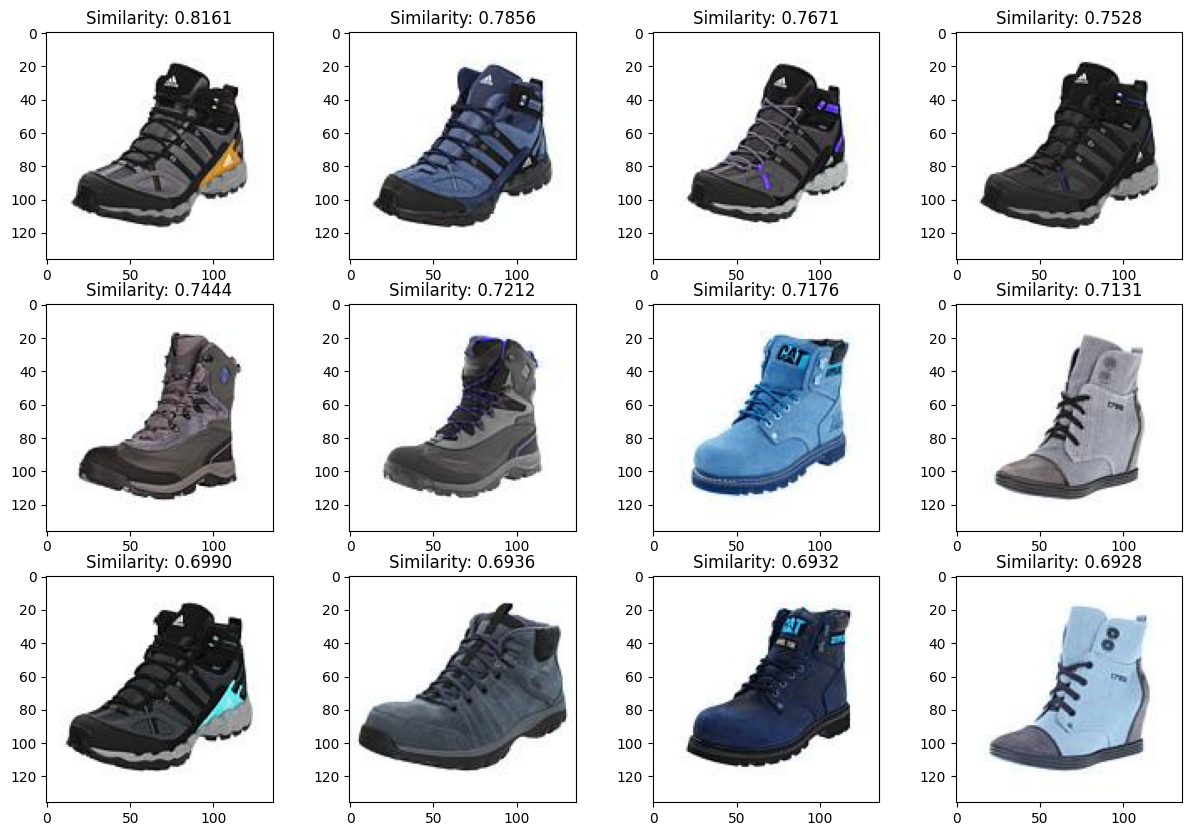

In [14]:
import os
import cv2
import numpy as np
from sklearn.neighbors import NearestNeighbors
from keras.applications.xception import Xception, preprocess_input
import matplotlib.pyplot as plt

images_dir = "C:\\Users\\hagar\\OneDrive\\Desktop\\GNN\\footwear\\ut-zap50k-images-square"
custom_query_image_path = "C:\\Users\\hagar\\OneDrive\\Desktop\\GNN\\footwear\\ut-zap50k-images-square\\ut-zap50k-images-square\\Boots\\Ankle\\New Balance\\8025309.155.jpg"  # Replace with the path to your custom image

def getImagePaths(path):
    # Function to Combine Directory Path with individual Image Paths
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

def preprocess_img(img_path):
    dsize = (299, 299)  # Xception input size
    new_image = cv2.imread(img_path)
    new_image = cv2.resize(new_image, dsize, interpolation=cv2.INTER_NEAREST)
    new_image = np.expand_dims(new_image, axis=0)
    new_image = preprocess_input(new_image)
    return new_image

def load_data():
    output = []
    for dirname, _, _ in os.walk(images_dir):
        output.extend(getImagePaths(dirname)[:50000])
    return output

def model():
    model = Xception(weights='imagenet', include_top=False)
    for layer in model.layers:
        layer.trainable = False
    return model

def feature_extraction(image_data, model):
    features = model.predict(image_data)
    features = np.array(features)
    features = features.flatten()
    return features

def result_vector_cosine(model, feature_vector, new_img):
    new_feature = model.predict(new_img)
    new_feature = np.array(new_feature)
    new_feature = new_feature.flatten()
    N_result = 12
    nbrs = NearestNeighbors(n_neighbors=N_result, metric="cosine").fit(feature_vector)
    distances, indices = nbrs.kneighbors([new_feature])
    return distances, indices

def input_show(data):
    plt.title("Query Image")
    plt.imshow(data)

def show_result(data, result, distances):
    fig = plt.figure(figsize=(15, 10))
    for i in range(0, 12):
        index_result = result[0][i]
        similarity_score = 1 - distances[0][i]  # Calculate similarity score
        plt.subplot(3, 4, i + 1)
        plt.imshow(cv2.imread(data[index_result]))
        plt.title(f"Similarity: {similarity_score:.4f}")
    plt.show()

def main():
    features = []
    output = load_data()
    main_model = model()

    # Process the custom query image
    custom_query_img = preprocess_img(custom_query_image_path)

    # Limiting the data for training
    for i in output[:999]:
        new_img = preprocess_img(i)
        features.append(feature_extraction(new_img, main_model))
    
    feature_vec = np.array(features)
    distances, result = result_vector_cosine(main_model, feature_vec, custom_query_img)
    input_show(cv2.imread(custom_query_image_path))
    show_result(output, result, distances)

if __name__ == '__main__':
    main()